# Linear Regression with MCMC Simulated Annealing

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from mcmc_optimization import optimize_via_mcmc
from models import LinearLayer
from data_samplers import BatchSampler
from proposal_generators import (
    LinearLayerUnivariateNormalProposalGenerator,
    LinearLayerMultivariateNormalProposalGenerator,
)

## Pure interpolation

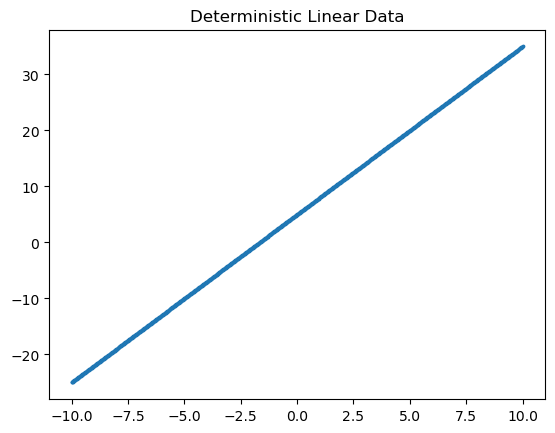

In [2]:
# Generate data.

true_function = lambda x: 3*x+5
len_data = 1000
x_vals = np.linspace(-10,10,len_data)
y_vals = true_function(x_vals)

plt.title("Deterministic Linear Data")
plt.scatter(x_vals, y_vals, s=3)
plt.show()

In the example below we use a Gaussian random walk for our proposal Markov Chain.

In [3]:
initial_params = {'w': 0.2, 'b': 6}
data_sampler = BatchSampler(X=x_vals, y=y_vals)
proposal_generator = LinearLayerUnivariateNormalProposalGenerator(stdev=1.1)

best_params, history = optimize_via_mcmc(LinearLayer, initial_params, data_sampler, proposal_generator, mean_squared_error)

In [4]:
print(f"Proportion of proposals accepted: {history['acceptance_ratio']:.4f}")
print(f"Best parameters found: w={best_params['w']}, b={best_params['b']}")
print(f"Best achieved loss: {min(history['loss_values']):.4f}")

Proportion of proposals accepted: 0.1544
Best parameters found: w=2.986471458987702, b=4.910385830112792
Best achieved loss: 0.0128


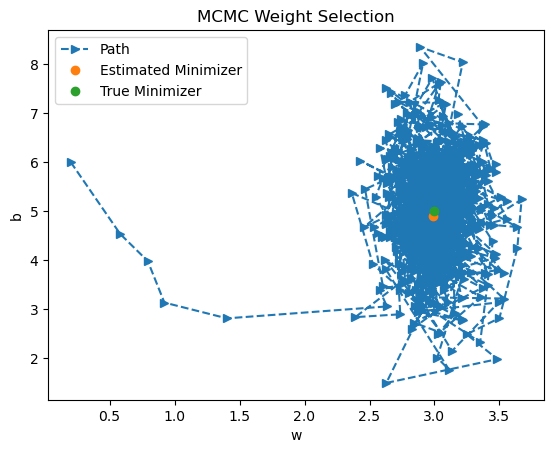

In [5]:
w_vals = history['parameter_values']['w']
b_vals = history['parameter_values']['b']

plt.plot(w_vals, b_vals, '-->', label="Path")
plt.plot(best_params['w'], best_params['b'], 'o', label="Estimated Minimizer")
plt.plot([3], [5], 'o', label="True Minimizer")
plt.xlabel("w")
plt.ylabel("b")
plt.legend()
plt.title("MCMC Weight Selection")
plt.show()

## Noisy regression (univariate contrived)

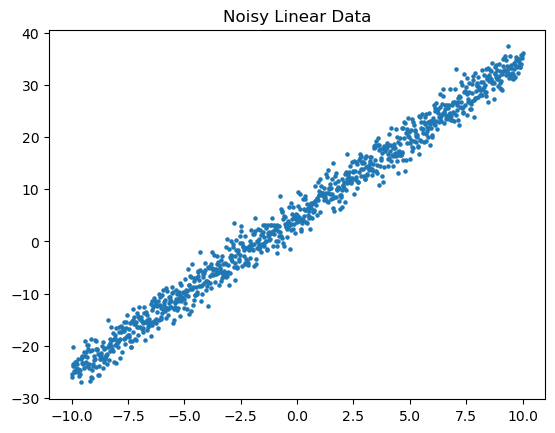

In [6]:
# Generate data.

true_function = lambda x: 3*x+5
len_data = 1000
x_vals = np.linspace(-10,10,len_data)
y_vals = true_function(x_vals) + np.random.normal(scale=2, size=len(x_vals))

plt.title("Noisy Linear Data")
plt.scatter(x_vals, y_vals, s=5)
plt.show()

In [7]:
# Fit linear regression model the standard way.

from sklearn.linear_model import LinearRegression

ground_truth_linear = LinearRegression().fit(x_vals.reshape(-1, 1), y_vals)

ground_truth_linear.coef_, ground_truth_linear.intercept_

(array([3.00222768]), 5.040554412665311)

In [8]:
# Fit linear regression model using MCMC.

initial_params = {'w': 0.2, 'b': 6}
data_sampler = BatchSampler(X=x_vals, y=y_vals)
proposal_generator = LinearLayerUnivariateNormalProposalGenerator(stdev=1.1)

best_params, history = optimize_via_mcmc(LinearLayer, initial_params, data_sampler,
                                         proposal_generator, mean_squared_error, num_iterations=10000)

In [9]:
print(f"Proportion of proposals accepted: {history['acceptance_ratio']:.4f}")
print(f"Best parameters found: w={best_params['w']}, b={best_params['b']}")
print(f"Best achieved loss: {min(history['loss_values']):.4f}")

Proportion of proposals accepted: 0.1680
Best parameters found: w=3.011775977276223, b=5.325006658766544
Best achieved loss: 1.4010


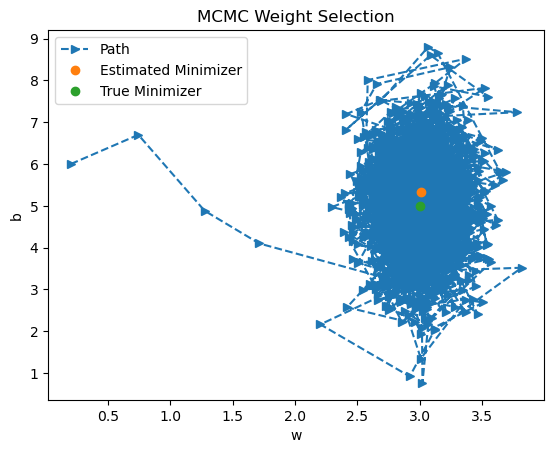

In [10]:
w_vals = history['parameter_values']['w']
b_vals = history['parameter_values']['b']

plt.plot(w_vals, b_vals, '-->', label="Path")
plt.plot(best_params['w'], best_params['b'], 'o', label="Estimated Minimizer")
plt.plot([3], [5], 'o', label="True Minimizer")
plt.xlabel("w")
plt.ylabel("b")
plt.legend()
plt.title("MCMC Weight Selection")
plt.show()

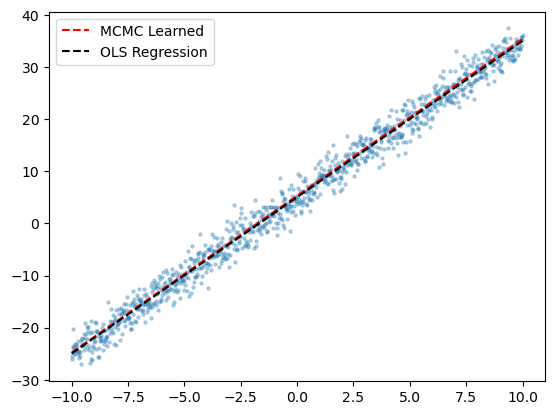

In [11]:
# Plot OLS regression against MCMC method.

plt.scatter(x_vals, y_vals, s=5, alpha=0.3)
plt.plot(x_vals, best_params['w'] * x_vals + best_params['b'], '--', label="MCMC Learned", c='r')
plt.plot(x_vals, ground_truth_linear.predict(x_vals.reshape(-1, 1)), '--', label="OLS Regression", c='k')

plt.legend()
plt.show()

## Real-life linear regression (multivariate)



In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15480, 8), (5160, 8), (15480,), (5160,))

In [13]:
ground_truth_linear = LinearRegression().fit(X_train, y_train)
actual_w, actual_b = ground_truth_linear.coef_, ground_truth_linear.intercept_

print(f"w = {np.round(actual_w, 3)}\n b = {actual_b}")
print(f"MSE = {mean_squared_error(y_train, ground_truth_linear.predict(X_train))}")

w = [ 0.438  0.009 -0.106  0.607 -0.    -0.003 -0.425 -0.438]
 b = -37.19914653918729
MSE = 0.5244357418709829


In [16]:
initial_params = {'w': np.random.normal(size=X_train.shape[1]), 'b': np.random.uniform(-30, 30)}
data_sampler = BatchSampler(X=X_train, y=y_train)
proposal_generator = LinearLayerMultivariateNormalProposalGenerator(cov=1.1, decay=(1 - 1e-7))

best_params, history = optimize_via_mcmc(LinearLayer, initial_params, data_sampler,
                                         proposal_generator, mean_squared_error, 
                                         beta=1e-4, num_iterations=25000, batch_size=150)

In [18]:
print(f"Proportion of proposals accepted: {history['acceptance_ratio']:.4f}")
print(f"Best parameters found: w={np.round(best_params['w'], 3)}, b={np.round(best_params['b'], 3)}")
print(f"Best achieved loss: {min(history['loss_values']):.4f}")

Proportion of proposals accepted: 0.0409
Best parameters found: w=[ 2.1410e+00 -1.0230e+00  3.1120e+00  1.0045e+01  2.0000e-03  4.7480e+00
  9.7500e+00  2.8370e+00], b=-21.389
Best achieved loss: 653.3761


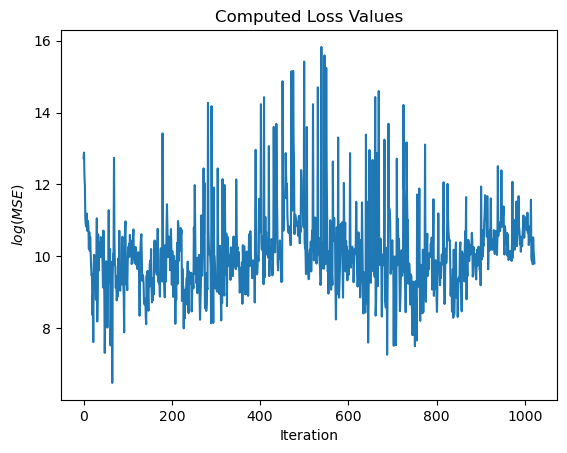

In [25]:
plt.title("Computed Loss Values")
plt.plot(np.log(history['loss_values']))
plt.ylabel("$log(MSE)$")
plt.xlabel("Iteration")
plt.show()

In [28]:
w_vals = np.row_stack(history['parameter_values']['w'])
b_vals = np.row_stack(history['parameter_values']['b'])

w_vals.shape, b_vals.shape

((1024, 8), (1024, 1))

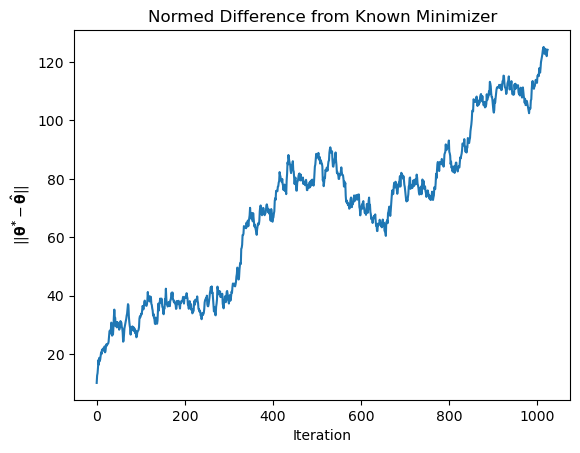

In [37]:
plt.title("Normed Difference from Known Minimizer")
plt.plot((np.linalg.norm(w_vals - actual_w, axis=1) + np.abs(b_vals - actual_b).ravel()))
plt.ylabel("$||\mathbf{\\theta^{*}} - \mathbf{\hat{\\theta}}||$")
plt.xlabel("Iteration")
plt.show()

In linear regression, at least, we are not approaching the optimizer with this method.